In [3]:
import tfim
import tfim_perturbation
import tfim_matrices
import tfim_rdm
import numpy as np
from scipy import sparse
from scipy.sparse import linalg as spla
from scipy import linalg
from scipy import optimize
import progressbar
import itertools
import matplotlib.pyplot as pl
import matplotlib.ticker as mtick
import schmidt_decomp

In [4]:
# Initial system specification
L = [2,2]
h_x_range = np.logspace(-2,-1, 100)
PBC = True
J = 1

In [5]:
def Jij_2D_NN(seed, N, PBC, xwidth, yheight, lattice):

    def bond_list(seed, N, PBC, xwidth, yheight):
        np.random.seed(seed)
        # Generates a random list of bonds with equal numbers of ferromagnetic and antiferromagnetic bonds
        if PBC == True:
            num_of_bonds = 2*N
        else:
            num_of_bonds = (xwidth - 1)*(yheight) + (xwidth)*(yheight - 1)
        if num_of_bonds%2 == 0:
            a1 = [-1 for i in range(num_of_bonds//2)]
        else:
            a1 = [-1 for i in range((num_of_bonds//2) + 1)]
        a2 = [1 for i in range(num_of_bonds//2)]
        a = list(np.random.permutation(a1+a2))
        return a

    def make_Jij(N, b_list, lattice):
        #Goes through the list of bonds to make the jij matrix that tells you how all of the spins are bonded to each other

        bond_index = 0
        Jij = np.zeros((N,N))
        for i in range(0,N):
            NNs = lattice.NN(i)
            for j in NNs:
                if Jij[i][j] == 0:
                    Jij[i][j] = b_list[bond_index]
                    Jij[j][i] = b_list[bond_index]
                    bond_index += 1
        return Jij
    
    b_list = bond_list(seed, N, PBC, xwidth, yheight)
    return make_Jij(N, b_list, lattice)

In [6]:
# search for 4th order approximable Jij matrices
seed_limit = 100
max_order = 4

# Build lattice and basis
lattice = tfim.Lattice(L, PBC)
N = lattice.N
basis = tfim.IsingBasis(lattice)

# Specifying parameters needed
seed_range = range(seed_limit)

# Begin search
Jij_array = [];

for i in seed_range:
    Jij = Jij_2D_NN(i, N, PBC, L[0], L[1], lattice)
    Jij_array.append(Jij)

# Calculate energy array:
indices_array = []

for Jij in Jij_array:
    Energies = -tfim.JZZ_SK_ME(basis,Jij)
    GS_energy = np.min(Energies)
    GS_indices = np.nonzero(Energies == GS_energy)[0]
    indices_array.append(GS_indices)

# Search for Hamming distance 2
seed_list = []

for index, indices in enumerate(indices_array):
    if tfim_perturbation.judge(max_order, tfim_perturbation.Hamming_array(indices, basis), N):
        seed_list.append(index)

print(seed_list)

[]


In [7]:
# # Build lattice and basis
# lattice = tfim.Lattice(L, PBC)
# N = lattice.N
# basis = tfim.IsingBasis(lattice)

In [8]:
#construct random J matrix
# Jij = tfim.Jij_instance(N,J,"bimodal",Jij_seed) 
Jij_3 = np.array([[-1, 1, 1]])
Jij_4 = np.array([[0, 1, 0, -1],[1, 1, 1, 1]])
# seed = 49
seed = 34
Jij = Jij_2D_NN(82, N, PBC, L[0], L[1], lattice)

In [9]:
# List out all the spin_states, corresponding indices and energies
Energies = -tfim.JZZ_SK_ME(basis,Jij)
for index in range(2**N):
    print(index, basis.state(index), Energies[index])

0 [0 0 0 0] -0.0
1 [0 0 0 1] 1.0
2 [0 0 1 0] 1.0
3 [0 0 1 1] 2.0
4 [0 1 0 0] 1.0
5 [0 1 0 1] -0.0
6 [0 1 1 0] -2.0
7 [0 1 1 1] -3.0
8 [1 0 0 0] -3.0
9 [1 0 0 1] -2.0
10 [1 0 1 0] -0.0
11 [1 0 1 1] 1.0
12 [1 1 0 0] 2.0
13 [1 1 0 1] 1.0
14 [1 1 1 0] 1.0
15 [1 1 1 1] -0.0


In [10]:
# Build a list of excited state indices that are one Hamming distances away from ground states
GS_energy, GS_indices = tfim_perturbation.GS(Energies)

In [11]:
np.shape(GS_indices)

(2,)

In [12]:
# Build exact matrix
V_exc = tfim_perturbation.V_exact(basis, lattice)

H_0_exc = tfim_perturbation.H_0_exact(Energies)

In [13]:
print(V_exc)

[[0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0.]]


In [10]:
# Calculate approximated eigenvalues and eigenstates for range(h_x)
app_eigenvalues, app_eigenstates = tfim_perturbation.app_4_eigensystem_general_matrices(GS_indices, GS_energy, h_x_range, J, N, basis, Jij)

In [11]:
# Calculate exact eigenvalues and eigenstates for range(h_x)
exc_eigenvalues, exc_eigenstates = tfim_perturbation.exc_eigensystem(basis, h_x_range, lattice, Energies)

In [12]:
# Extract exact ground states
exc_GS_eigenstates = np.zeros((len(h_x_range), len(GS_indices), len(GS_indices)))

for i in range(len(h_x_range)):
    for m, j in enumerate(GS_indices):
        for n, k in enumerate(GS_indices):
            exc_GS_eigenstates[i, m, n] = exc_eigenstates[i, j, n]

In [13]:
reordered_app_eigenstates = np.zeros([len(h_x_range), len(GS_indices), len(GS_indices)])
epsilon = 1*10**(-6)

for h_x_index in range(len(h_x_range)):
    if h_x_index < 2:
        reordered_app_eigenstates[h_x_index] = app_eigenstates[h_x_index]
    else: 
        for k in range(len(GS_indices)//2):
            fidelity_array = []
            for v1 in [reordered_app_eigenstates[h_x_index-1, :, 2*k], reordered_app_eigenstates[h_x_index-1, :, 2*k+1]]:
                for v2 in [app_eigenstates[h_x_index, :, 2*k], app_eigenstates[h_x_index, :, 2*k+1]]:
                    fidelity_array = np.append(fidelity_array,tfim_perturbation.fidelity(v1,v2))
            if abs(fidelity_array[0] - max(fidelity_array)) < epsilon:
                reordered_app_eigenstates[h_x_index, :, 2*k] = app_eigenstates[h_x_index, :, 2*k]
                reordered_app_eigenstates[h_x_index, :, 2*k + 1] = app_eigenstates[h_x_index, :, 2*k + 1]
            else:
                reordered_app_eigenstates[h_x_index, :, 2*k] = app_eigenstates[h_x_index, :, 2*k + 1]
                reordered_app_eigenstates[h_x_index, :, 2*k + 1] = app_eigenstates[h_x_index, :, 2*k]

In [14]:
reordered_exc_GS_eigenstates = np.zeros([len(h_x_range), len(GS_indices), len(GS_indices)])
epsilon = 1*10**(-12)

for h_x_index in range(len(h_x_range)):
    if h_x_index < 2:
        reordered_exc_GS_eigenstates[h_x_index] = exc_GS_eigenstates[h_x_index]
    else: 
        for k in range(len(GS_indices)//2):
            fidelity_array = []
            for v1 in [reordered_exc_GS_eigenstates[h_x_index-1, :, 2*k], reordered_exc_GS_eigenstates[h_x_index-1, :, 2*k+1]]:
                for v2 in [exc_GS_eigenstates[h_x_index, :, 2*k], exc_GS_eigenstates[h_x_index, :, 2*k+1]]:
                    fidelity_array = np.append(fidelity_array,tfim_perturbation.fidelity(v1,v2))
            if abs(fidelity_array[0] - max(fidelity_array)) < epsilon:
                reordered_exc_GS_eigenstates[h_x_index, :, 2*k] = exc_GS_eigenstates[h_x_index, :, 2*k]
                reordered_exc_GS_eigenstates[h_x_index, :, 2*k + 1] = exc_GS_eigenstates[h_x_index, :, 2*k + 1]
            else:
                reordered_exc_GS_eigenstates[h_x_index, :, 2*k] = exc_GS_eigenstates[h_x_index, :, 2*k + 1]
                reordered_exc_GS_eigenstates[h_x_index, :, 2*k + 1] = exc_GS_eigenstates[h_x_index, :, 2*k]

In [15]:
# Need to find the overall ground state wavefunction during perturbation
# A = [0,1,4,5,8]
# B = [2,3,6,7] # this is partition 2

# A = [1,4,6,8]
# B = [0,5,2,3,7] # this is partition 1

# A = [0,2,4,6,8]
# B = [1,3,5,7]

A = [0,1]
B = [2,3]
# this number 5 is arbitrary, only serves to give the index of the overall ground state
overall_perturb_GS = reordered_app_eigenstates[ :, :, np.argmin(app_eigenvalues.T[5])]
overall_exc_GS = reordered_exc_GS_eigenstates[ :, :, np.argmin(exc_eigenvalues.T[5])]

In [16]:
# # fidelity check
# fidelity_array = np.zeros(len(h_x_range))

# for i, h_x in enumerate(h_x_range):
#     fidelity_array[i] = tfim_perturbation.fidelity(exc_GS_eigenstates[i, :, 3], app_eigenstates[i, :, 3])
        
# fig = pl.figure(figsize=(8, 6))
# pl.rcParams['font.size'] = '18'
# pl.plot(h_x_range ,fidelity_array, lw=1.3, ls='-', label= "fidelity between perturbation and true quantum ground state")
# pl.ylabel('fidelity', fontsize=18)
# pl.xlabel('perturbation parameter', fontsize=18)
# # pl.axis([np.power(10, sigma_v)[lowerbound], np.power(10, sigma_v)[upperbound], chisq[lowerbound], chisq[upperbound]])
# pl.xticks(fontsize=18)
# pl.yticks(fontsize=18)
# pl.tick_params('both', length=7, width=2, which='major')
# pl.tick_params('both', length=5, width=2, which='minor')
# pl.grid(False)
# pl.xscale('log')
# # pl.yscale('log')
# pl.legend(bbox_to_anchor=(1.2,1), loc="upper left", prop={'size': 16}, numpoints=1, scatterpoints=1, ncol=1)

In [17]:
# quantum_GS = np.zeros((len(GS_indices),len(h_x_range)))

# for i in range(len(GS_indices)):
#     for j in range(len(h_x_range)):        
#         energies = exc_eigenvalues[:, i]
#         idk = np.argpartition(energies, len(GS_indices))
#         lowest_energies=energies[idk[:len(GS_indices)]]
#         quantum_GS[i, j] = lowest_energies[i]
        
# for i in range(len(GS_indices)):
#     pl.plot(h_x_range, quantum_GS[i])

In [18]:
def partition_basis(basis, GS_indices, A, B):
    
    # building initial basis as set since to avoid repeated elements
    A_basis = set()
    B_basis = set()
    
    for index, GS_index in np.ndenumerate(GS_indices):
        state = basis.state(GS_index)
        A_basis.add(tuple(state[A]))
        B_basis.add(tuple(state[B]))
    
    def sum_digits(digits): 
        return sum(c << i for i, c in enumerate(digits)) 
    
    # now we extract the elements from this set and start building the ordered
    # basis
    
    # reordering basis A
    index_matching_A = {}

    for ele in A_basis:
        ele = np.array(ele)
        index_matching_A[sum_digits(ele)] = np.array(ele)

    A_reordered_basis = np.zeros((len(index_matching_A),len(list(index_matching_A.values())[0])))
    for index, key in enumerate(index_matching_A.keys()):
        A_reordered_basis[index] = index_matching_A[key]
    
    # reordering basis B
    index_matching_B = {}

    for ele in B_basis:
        ele = np.array(ele)
        index_matching_B[sum_digits(ele)] = np.array(ele)

    B_reordered_basis = np.zeros((len(index_matching_B),len(list(index_matching_B.values())[0])))
    for index, key in enumerate(index_matching_B.keys()):
        B_reordered_basis[index] = index_matching_B[key]
        
    return A_reordered_basis, B_reordered_basis

A_basis, B_basis = partition_basis(basis, GS_indices, A, B)

In [19]:
def beta_ij(basis, GS_indices, A, B, overall_GS, perturbation_param_index):
    # this function builds beta_ij matrix as a function of the index of the perturbation parameter

    # build A, B basis first
    A_basis, B_basis = partition_basis(basis, GS_indices, A, B)
    s = overall_GS[perturbation_param_index]

    def find(basis, target):
        # this function finds the index of the target state in the basis state, gives the index of 1 in BETA
        for i, state in enumerate(basis):
            if np.array_equiv(state, target):
                return i

    BETA = np.zeros((len(A_basis),len(B_basis)))

    for (probability, GS_index) in zip(s, GS_indices):
        GS_state = basis.state(GS_index)
        i = find(A_basis, GS_state[A])
        j = find(B_basis, GS_state[B])
        BETA[i, j] += probability
    return BETA

In [20]:
def perturb_entropy(perturbation_param_index):
    
    BETA = beta_ij(basis, GS_indices, A, B, overall_GS, perturbation_param_index)

    # perform uv decomposition

    u, s, vh = np.linalg.svd(BETA, full_matrices=True)
    
    s = s[np.where(s != 0.)]
    # add conditional statement to remove all the zero singular values

    entropy = -np.dot(s**2, np.log(s**2))
    
    return entropy

def exc_entropy(perturbation_param_index):
    psi0 = exc_eigenstates[ :, :, np.argmin(exc_eigenvalues.T[5])]
    S, U, V = tfim_rdm.svd(basis, A, B, psi0[perturbation_param_index])
    entropy = tfim_rdm.entropy(S)
    return entropy

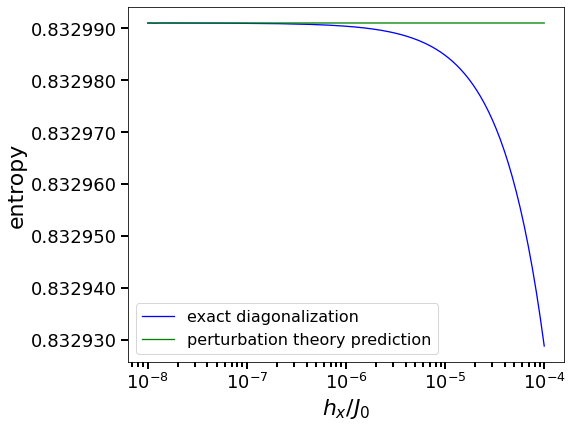

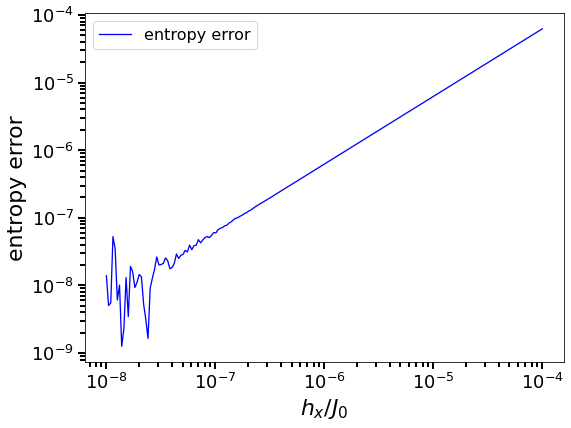

In [21]:
perturb_entropy_arr = np.zeros(len(h_x_range))
exc_entropy_arr = np.zeros(len(h_x_range))

for i in range(len(h_x_range)):
    perturb_entropy_arr[i] = schmidt_decomp.perturb_entropy(basis, GS_indices, A, B, overall_perturb_GS, i)
    exc_entropy_arr[i] = schmidt_decomp.exc_entropy(basis, exc_eigenstates, exc_eigenvalues, A, B, i)

# convergence plot
fig = pl.figure(figsize=(8, 6))
pl.rcParams['font.size'] = '18'
pl.plot(h_x_range,exc_entropy_arr, lw=1.3, ls='-', color="blue", label= "exact diagonalization")
pl.plot(h_x_range,perturb_entropy_arr, lw=1.3, ls='-', color="green", label = "perturbation theory prediction")
pl.ylabel('entropy', fontsize=22)
pl.xlabel(r'$h_x/J_0$', fontsize=22)
# pl.axis([np.power(10, sigma_v)[lowerbound], np.power(10, sigma_v)[upperbound], chisq[lowerbound], chisq[upperbound]])
pl.xticks(fontsize=18)
pl.yticks(fontsize=18)
pl.tick_params('both', length=7, width=2, which='major')
pl.tick_params('both', length=5, width=2, which='minor')
pl.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter('%.6f'))
pl.grid(False)
pl.xscale('log')
pl.legend(loc=0, prop={'size': 16}, numpoints=1, scatterpoints=1, ncol=1)
fig.tight_layout(pad=0.5)

# error plot

# Boundary index for the plot
fig = pl.figure(figsize=(8, 6))
pl.rcParams['font.size'] = '18'
pl.plot(h_x_range,abs(exc_entropy_arr-perturb_entropy_arr), lw=1.3, ls='-', color="blue", label= "entropy error")
pl.ylabel('entropy error', fontsize=22)
pl.xlabel(r'$h_x/J_0$', fontsize=22)
# pl.axis([np.power(10, sigma_v)[lowerbound], np.power(10, sigma_v)[upperbound], chisq[lowerbound], chisq[upperbound]])
pl.xticks(fontsize=18)
pl.yticks(fontsize=18)
pl.tick_params('both', length=7, width=2, which='major')
pl.tick_params('both', length=5, width=2, which='minor')
pl.grid(False)
pl.xscale('log')
pl.yscale('log')
pl.legend(loc = 0 , prop={'size': 16}, numpoints=1, scatterpoints=1, ncol=1)
fig.tight_layout(pad=0.5)

In [25]:
# For the paper, include 2 plots
# plot my perturbation theory result 2nd order y axis entropy and x axis h where since the quantum ground state
# degeneracy is fully split, then the entropy is just a constant since the eigenstate does not depend on h value, then compare it to the exact result
# where the ground state will depend on h, this plot will show that as h approaches 0
# 2nd plot is the error between the entropies of exact and approx. and we expect it to be a power law

# next step for the project: bound the error for the quantum ground state by performing perturbation theory on excited states
perturb_entropy_arr[5]

0.8329910625820104

In [23]:
# include a few instances of 3 by 3 and 4 by 4 instances and compare
# the exact vs the perturbation theory result for the paper

In [24]:
# use Ellie and Jack's code to generate visualizations for square lattice
# look at a few different instances and a few different bipartitions for each